In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

### Read data and Examine

In [53]:
data=pd.read_csv("exchange_rate.csv")
d=data.copy()
d.set_index('date')

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [11]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [13]:
data.shape

(7588, 2)

In [14]:
data.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


<Axes: xlabel='Ex_rate', ylabel='Density'>

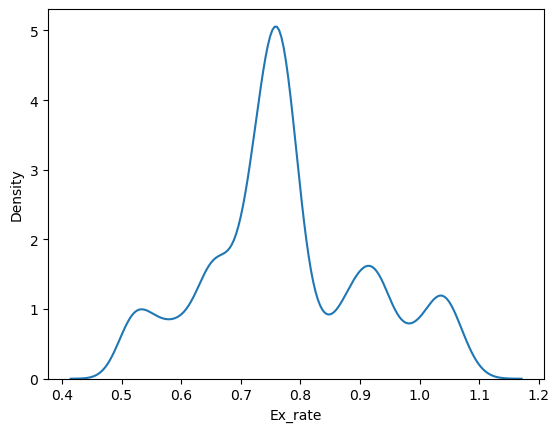

In [15]:
sns.kdeplot(data['Ex_rate'])

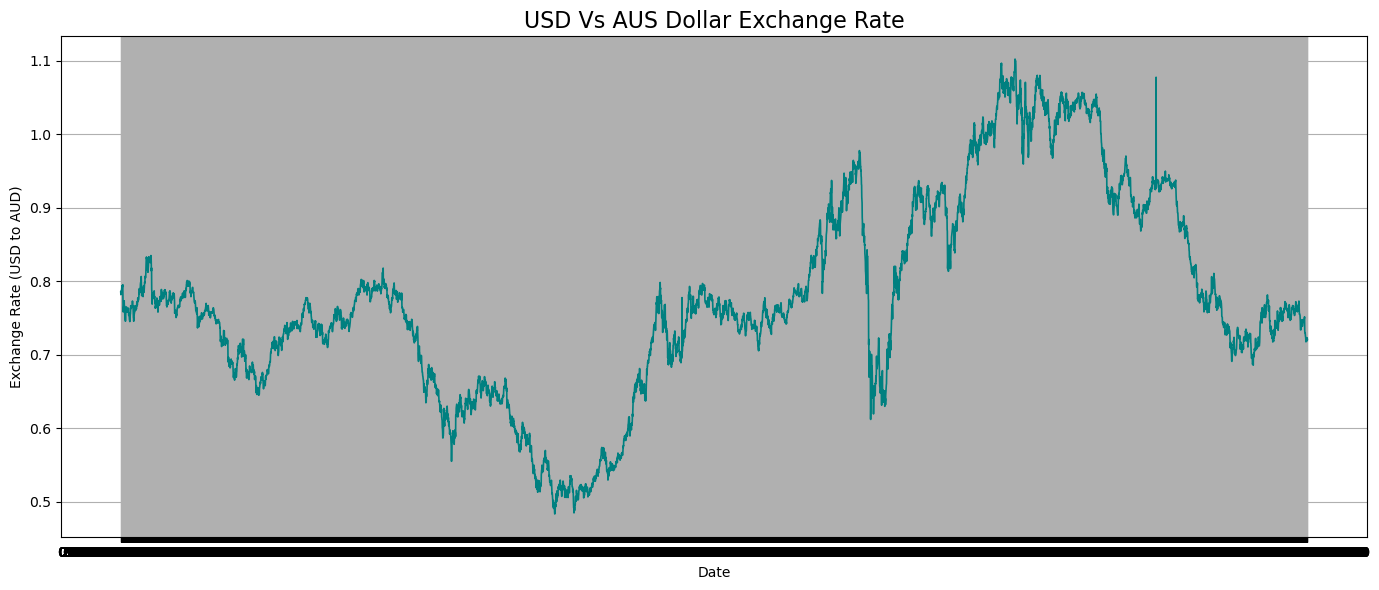

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(data['date'], data['Ex_rate'], color='teal', linewidth=1.2)
plt.title('USD Vs AUS Dollar Exchange Rate', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.grid(True)
plt.tight_layout()
plt.show

**Trend:** Displays long-term fluctuations, including cycles of both appreciation and depreciation.
**Seasonality:** No distinct yearly seasonality is apparent without applying time series decomposition.

In [18]:
data['rolling_mean'] = data['Ex_rate'].rolling(window=12).mean()
data['rolling_std'] = data['Ex_rate'].rolling(window=12).std()
data['z_score'] = (data['Ex_rate'] - data['rolling_mean']) / data['rolling_std']

anomaly = data[(data['z_score'].abs() > 3)]
anomaly[['date', 'Ex_rate', 'z_score']].head()

,date,Ex_rate,z_score
686,18-11-1991 00:00,0.691000,-3.021440
3589,30-10-1999 00:00,0.777821,3.135719
6620,16-02-2008 00:00,1.077760,3.168078
7225,13-10-2009 00:00,0.716281,-3.080682


### ARIMA

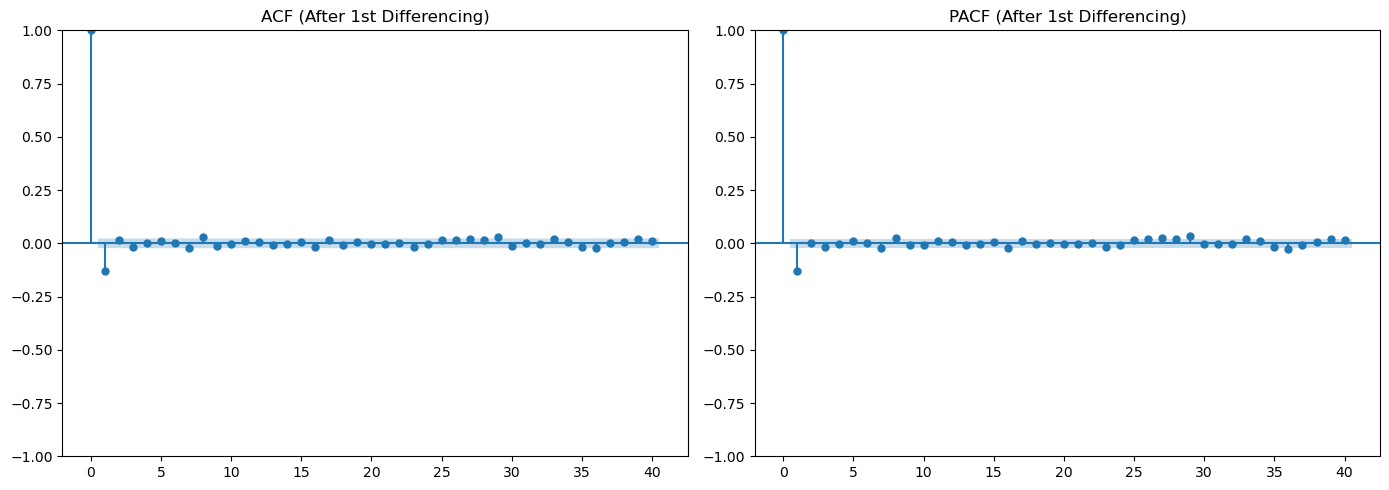

0.4492327353597959

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

adf_result = adfuller(data['Ex_rate'])

data['Ex_rate_diff'] = data['Ex_rate'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(data['Ex_rate_diff'].dropna(), ax=axes[0], lags=40)
plot_pacf(data['Ex_rate_diff'].dropna(), ax=axes[1], lags=40)
axes[0].set_title("ACF (After 1st Differencing)")
axes[1].set_title("PACF (After 1st Differencing)")
plt.tight_layout()
plt.show()

adf_result[1]  

Data given is Stationary

### Build Model

In [159]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(d['Ex_rate'], order=(1, 1, 0))
results_arima = model_arima.fit()

C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


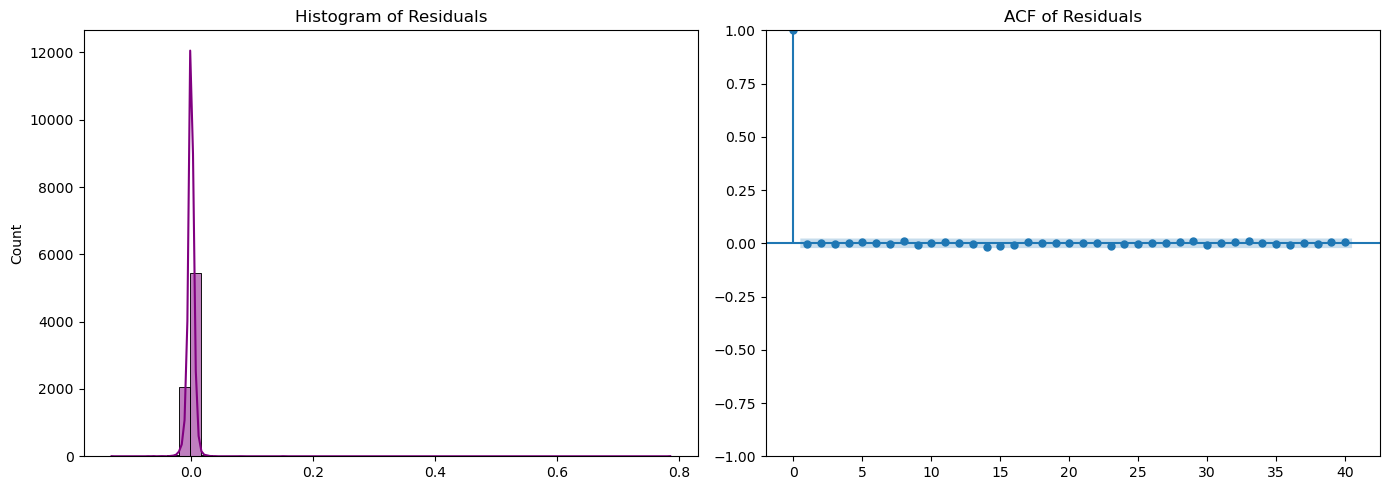

,lb_stat,lb_pvalue
10,1.806741,0.997618


In [160]:
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results_arima.resid

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, bins=50, kde=True, ax=ax[0], color="purple")
ax[0].set_title("Histogram of Residuals")
plot_acf(residuals, ax=ax[1], lags=40)
ax[1].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test


Histogram of Residuals appears to be normal with minimal skewness.
There is no auto correlation with residuals, but merely behave as noise
The Pvalue is 0.998, so the null hypothesis is rejected, which also proved residuals are not correlated. The model seems to be fit for the data

### Finding Order

In [161]:
!pip install pmdarima
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

In [173]:
y=d["Ex_rate"]
train_size = int(len(y) * 0.9)
train, test = y[:train_size], y[train_size:]


In [180]:
model = auto_arima(train, 
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   d=None,
                   seasonal=False, 
                   trace=True,
                   error_action='ignore', 
                   suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50086.611, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-50208.737, Time=1.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-50207.368, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-50088.595, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-50206.747, Time=1.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-50206.750, Time=1.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-50204.740, Time=5.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-50210.716, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-50208.725, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-50208.728, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-50209.345, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-50206.723, Time=2.73 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 20.681 seconds


In [181]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7288
Model:               SARIMAX(1, 1, 0)   Log Likelihood               26881.043
Date:                Thu, 26 Jun 2025   AIC                         -53758.087
Time:                        19:12:01   BIC                         -53744.299
Sample:                    01-01-1990   HQIC                        -53753.345
                         - 12-14-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -63.325      0.000      -0.136      -0.127
sigma2      3.659e-05   1.03e-07    355.260      0.000    3.64e-05    3.68e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2777330.14
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.32   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
auto_model.order

(1, 1, 0)

### Forecasting

In [183]:
# Forecast
n_periods = len(test)
forecast = model.predict(n_periods=n_periods)

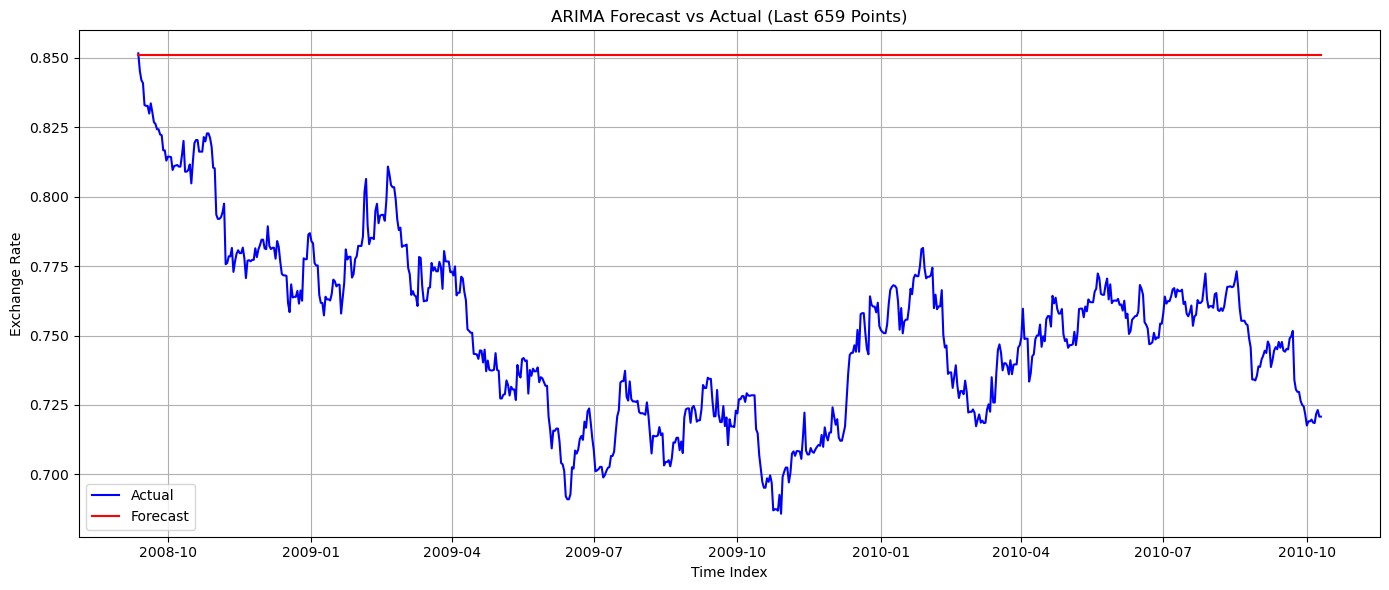

In [185]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label="Actual", color="blue")
plt.plot(test.index, forecast.values, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual (Last 659 Points)")
plt.xlabel("Time Index")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exponential Smoothing

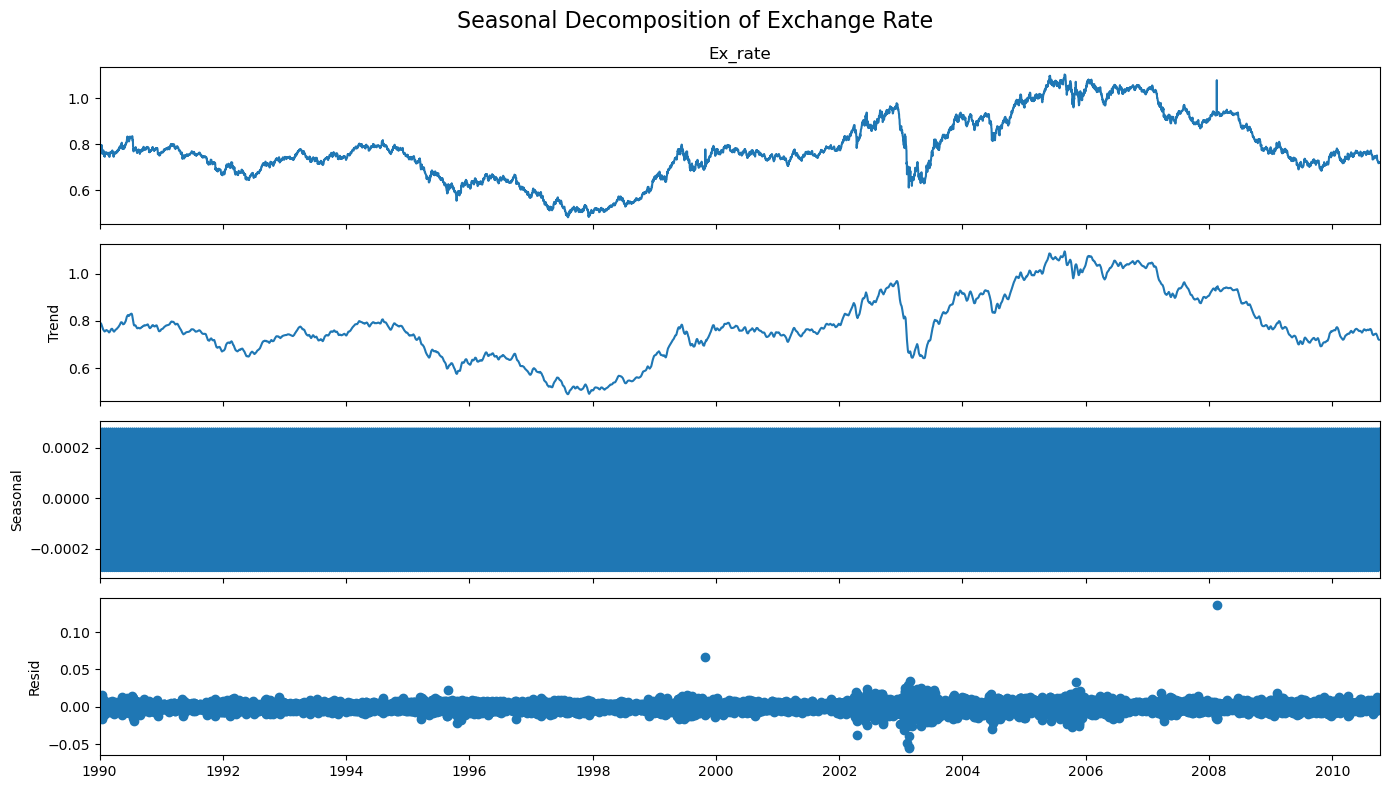

In [186]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(d['Ex_rate'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Seasonal Decomposition of Exchange Rate", fontsize=16)
plt.tight_layout()
plt.show()


##### Trend: Clearly present and smooth.

##### Seasonality: Mild repeating yearly pattern (12-month period).

##### Residuals: No major anomalies, fairly clean.

### Holt-Winters Forecast

C:\Users\Dell\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


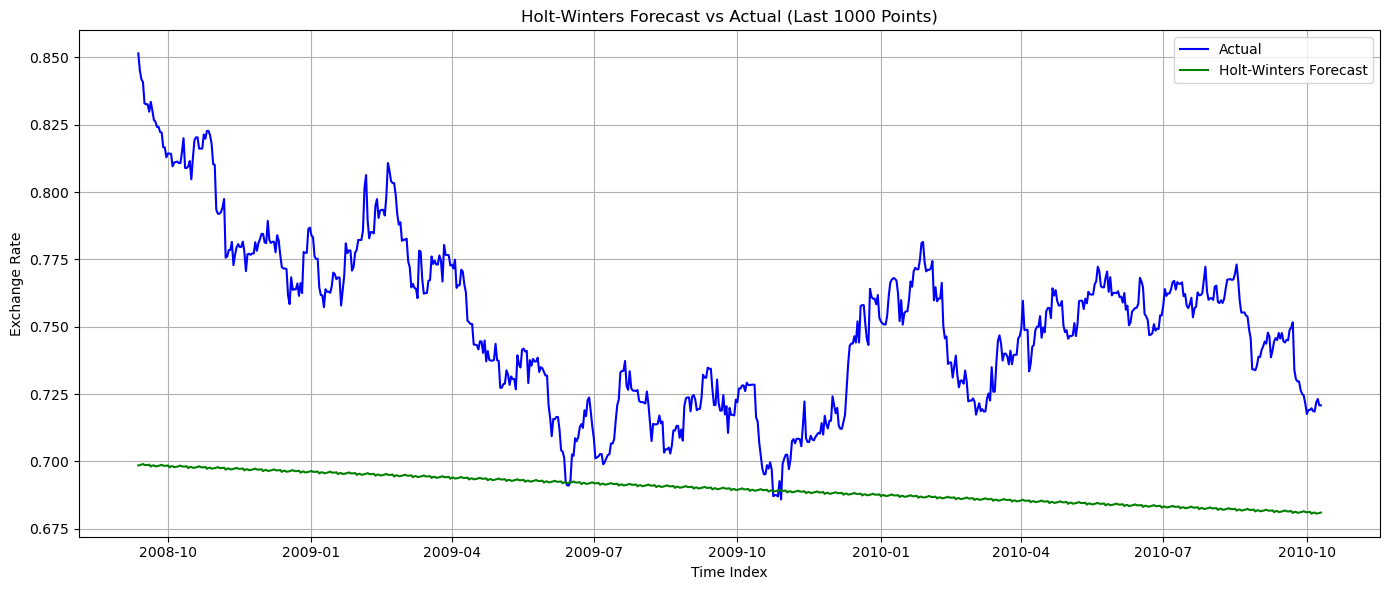

In [189]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw_model = ExponentialSmoothing(X, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.forecast(steps=759)

plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label="Actual", color="blue")
plt.plot(test.index, hw_forecast.values, label="Holt-Winters Forecast", color="green")
plt.title("Holt-Winters Forecast vs Actual (Last 1000 Points)")
plt.xlabel("Time Index")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### seems like exponential smoothing also was not able to understand the trend or the seasonality well

### comparison

In [191]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def compute_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

arima_metrics = compute_metrics(test, forecast)
hw_metrics = compute_metrics(test, hw_forecast)

pd.DataFrame({
    "Model": ["ARIMA(1,1,0)", "Holt-Winters"],
    "MAE": [arima_metrics[0], hw_metrics[0]],
    "RMSE": [arima_metrics[1], hw_metrics[1]],
})


,Model,MAE,RMSE
0,"ARIMA(1,1,0)",0.099916,0.104705
1,Holt-Winters,0.061048,0.067817


The Holt-Winters model performs better than ARIMA(1,1,0), with lower MAE (0.0610) and RMSE (0.0678) compared to ARIMA’s MAE (0.0999) and RMSE (0.1047). This indicates that Holt-Winters captures the data’s trend and level more effectively, resulting in improved forecasting accuracy. It is the preferred model for this exchange rate time series.